In [1]:
import arrow
import datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import pickle
import xarray as xr

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

## The Grid ##

In [3]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
#mesh = nc.Dataset('../../../myResults/mesh_mask201702.nc')
gdepw = mesh.variables['gdepw_1d'][0]
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
#bathy = nc.Dataset('../../../myResults/bathymetry_201702.nc')
lats = bathy.variables['nav_lat'][:]
lons = bathy.variables['nav_lon'][:]
gdept = mesh.variables['gdept_1d'][0]
mesh.close()
bathy.close()

## Get the Data ##

In [4]:
Vic_to_PR_2015 = pd.read_csv('Vic_to_PR_2015.csv', index_col=0)
Vic_to_PR_2016 = pd.read_csv('Vic_to_PR_2016.csv', index_col=0)
Vic_to_PR_2017 = pd.read_csv('Vic_to_PR_2017.csv', index_col=0)
Vic_to_PR_2015_v3 = pd.read_csv('Vic_to_PR_2015_v3.csv', index_col=0)

Vic_to_GI_2015 = pd.read_csv('Vic_to_GI_2015.csv', index_col=0)
Vic_to_GI_2016 = pd.read_csv('Vic_to_GI_2016.csv', index_col=0)
Vic_to_GI_2017 = pd.read_csv('Vic_to_GI_2017.csv', index_col=0)
Vic_to_GI_2015_v3 = pd.read_csv('Vic_to_GI_2015_v3.csv', index_col=0)

PR_from_Vic_2015 = pd.read_csv('PR_from_Vic_2015.csv', index_col=0)
PR_from_Vic_2016 = pd.read_csv('PR_from_Vic_2016.csv', index_col=0)
PR_from_Vic_2017 = pd.read_csv('PR_from_Vic_2017.csv', index_col=0)
PR_from_Vic_2015_v3 = pd.read_csv('PR_from_Vic_2015_v3.csv', index_col=0)

GI_from_Vic_2015 = pd.read_csv('GI_from_Vic_2015.csv', index_col=0)
GI_from_Vic_2016 = pd.read_csv('GI_from_Vic_2016.csv', index_col=0)
GI_from_Vic_2017 = pd.read_csv('GI_from_Vic_2017.csv', index_col=0)
GI_from_Vic_2015_v3 = pd.read_csv('GI_from_Vic_2015_v3.csv', index_col=0)

PR_to_Vic_2015 = pd.read_csv('PR_to_Vic_2015.csv', index_col=0)
PR_to_Vic_2016 = pd.read_csv('PR_to_Vic_2016.csv', index_col=0)
PR_to_Vic_2017 = pd.read_csv('PR_to_Vic_2017.csv', index_col=0)
PR_to_Vic_2015_v3 = pd.read_csv('PR_to_Vic_2015_v3.csv', index_col=0)

GI_to_Vic_2015 = pd.read_csv('GI_to_Vic_2015.csv', index_col=0)
GI_to_Vic_2016 = pd.read_csv('GI_to_Vic_2016.csv', index_col=0)
GI_to_Vic_2017 = pd.read_csv('GI_to_Vic_2017.csv', index_col=0)
GI_to_Vic_2015_v3 = pd.read_csv('GI_to_Vic_2015_v3.csv', index_col=0)

Vic_from_PR_2015 = pd.read_csv('Vic_from_PR_2015.csv', index_col=0)
Vic_from_PR_2016 = pd.read_csv('Vic_from_PR_2016.csv', index_col=0)
Vic_from_PR_2017 = pd.read_csv('Vic_from_PR_2017.csv', index_col=0)
Vic_from_PR_2015_v3 = pd.read_csv('Vic_from_PR_2015_v3.csv', index_col=0)

Vic_from_GI_2015 = pd.read_csv('Vic_from_GI_2015.csv', index_col=0)
Vic_from_GI_2016 = pd.read_csv('Vic_from_GI_2016.csv', index_col=0)
Vic_from_GI_2017 = pd.read_csv('Vic_from_GI_2017.csv', index_col=0)
Vic_from_GI_2015_v3 = pd.read_csv('Vic_from_GI_2015_v3.csv', index_col=0)


In [5]:
def combine_GI_PR(Vic_to_PR_2015, Vic_to_GI_2015):
    Vic_to_SoG_2015 = Vic_to_PR_2015.copy()
    for key in Vic_to_PR_2015.keys():
        if key == 'transport':
            Vic_to_SoG_2015.transport = Vic_to_PR_2015.transport + Vic_to_GI_2015.transport
        else:
            Vic_to_SoG_2015[key] = ((Vic_to_PR_2015[key] * Vic_to_PR_2015.transport 
                                + Vic_to_GI_2015[key] * Vic_to_GI_2015.transport) /
                            (Vic_to_PR_2015.transport + Vic_to_GI_2015.transport))
    return Vic_to_SoG_2015

In [6]:
Vic_to_SoG_2015 = combine_GI_PR(Vic_to_PR_2015, Vic_to_GI_2015)
Vic_to_SoG_2015_v3 = combine_GI_PR(Vic_to_PR_2015_v3, Vic_to_GI_2015_v3)
SoG_from_Vic_2015 = combine_GI_PR(PR_from_Vic_2015, GI_from_Vic_2015)
SoG_from_Vic_2015_v3 = combine_GI_PR(PR_from_Vic_2015_v3, GI_from_Vic_2015_v3)

In [7]:
Vic_to_SoG_2016 = combine_GI_PR(Vic_to_PR_2016, Vic_to_GI_2016)
SoG_from_Vic_2016 = combine_GI_PR(PR_from_Vic_2016, GI_from_Vic_2016)

In [8]:
Vic_to_SoG_2017 = combine_GI_PR(Vic_to_PR_2017, Vic_to_GI_2017)
SoG_from_Vic_2017 = combine_GI_PR(PR_from_Vic_2017, GI_from_Vic_2017)

In [9]:
SoG_to_Vic_2015 = combine_GI_PR(PR_to_Vic_2015, GI_to_Vic_2015)
SoG_to_Vic_2015_v3 = combine_GI_PR(PR_to_Vic_2015_v3, GI_to_Vic_2015_v3)
Vic_from_SoG_2015 = combine_GI_PR(Vic_from_PR_2015, Vic_from_GI_2015)
Vic_from_SoG_2015_v3 = combine_GI_PR(Vic_from_PR_2015_v3, Vic_from_GI_2015_v3)

In [10]:
SoG_to_Vic_2016 = combine_GI_PR(PR_to_Vic_2016, GI_to_Vic_2016)
Vic_from_SoG_2016 = combine_GI_PR(Vic_from_PR_2016, Vic_from_GI_2016)

In [11]:
SoG_to_Vic_2017 = combine_GI_PR(PR_to_Vic_2017, GI_to_Vic_2017)
Vic_from_SoG_2017 = combine_GI_PR(Vic_from_PR_2017, Vic_from_GI_2017)

In [12]:
for df in [Vic_to_PR_2015, Vic_to_PR_2016,
           Vic_to_GI_2015, Vic_to_GI_2016,
           Vic_to_SoG_2015, SoG_from_Vic_2015,
           Vic_to_SoG_2016, SoG_from_Vic_2016,
           Vic_to_SoG_2017, SoG_from_Vic_2017,
           Vic_from_SoG_2015, SoG_to_Vic_2015,
           Vic_from_SoG_2016, SoG_to_Vic_2016,
           Vic_from_SoG_2017, SoG_to_Vic_2017,
           PR_from_Vic_2015, PR_from_Vic_2016,
           GI_from_Vic_2015, GI_from_Vic_2016,
           PR_to_Vic_2015, PR_to_Vic_2016,
           GI_to_Vic_2015, GI_to_Vic_2016,
           Vic_from_PR_2015, Vic_from_PR_2016,
           Vic_from_GI_2015, Vic_from_GI_2016,
           Vic_to_SoG_2015_v3, Vic_from_SoG_2015_v3,
           SoG_from_Vic_2015_v3, SoG_to_Vic_2015_v3,
          ]:
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M:%S+00:00")

In [13]:
def correct_time(Vic_to_SoG_2015, basic, factor):
    corrected_time =np.empty_like(np.array(Vic_to_SoG_2015.index))
    for i, index in enumerate(Vic_to_SoG_2015.index):
        corrected_time[i] = index + datetime.timedelta(days=basic+Vic_to_SoG_2015.final_age[i]*factor)
    Vic_to_SoG_2015['correct_time'] = corrected_time
    return (Vic_to_SoG_2015)

In [14]:
def merge(df, df2):
    nidx = df.index
    ndf = df.set_index('correct_time')
    oidx = ndf.index
   
    res = ndf.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx)
    nidx = df2.index
    ndf2 = df2.set_index('correct_time')
    oidx = ndf2.index

    res2 = ndf2.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx)
    corr = (res.transport.corr(res2.transport))
    res.transport = 0.5*(res.transport + res2.transport)
    return res, corr


In [15]:
basic, factor = -12.1, 1.1
Vic_to_SoG_2015 = correct_time(Vic_to_SoG_2015, basic=basic, factor=factor)
Vic_to_SoG_2015_v3 = correct_time(Vic_to_SoG_2015_v3, basic=basic, factor=factor)

SoG_from_Vic_2015 = correct_time(SoG_from_Vic_2015, basic=-basic, factor=-factor)
SoG_from_Vic_2015_v3 = correct_time(SoG_from_Vic_2015_v3, basic=-basic, factor=-factor)
deep_flux_2015, corr = merge(Vic_to_SoG_2015, SoG_from_Vic_2015)
deep_flux_2015_v3, corr = merge(Vic_to_SoG_2015_v3, SoG_from_Vic_2015_v3)

In [16]:
basic, factor = -12.1, 1.1
Vic_to_SoG_2016 = correct_time(Vic_to_SoG_2016, basic=basic, factor=factor)
SoG_from_Vic_2016 = correct_time(SoG_from_Vic_2016, basic=-basic, factor=-factor)
deep_flux_2016, corr = merge(Vic_to_SoG_2016, SoG_from_Vic_2016)

In [17]:
basic, factor = -12.1, 1.1
Vic_to_SoG_2017 = correct_time(Vic_to_SoG_2017, basic=basic, factor=factor)
SoG_from_Vic_2017 = correct_time(SoG_from_Vic_2017, basic=-basic, factor=-factor)
deep_flux_2017, corr = merge(Vic_to_SoG_2017, SoG_from_Vic_2017)

In [18]:
basic, factor = -3.5, 0.61
Vic_from_SoG_2015 = correct_time(Vic_from_SoG_2015, basic=-basic, factor=-factor)
Vic_from_SoG_2015_v3 = correct_time(Vic_from_SoG_2015_v3, basic=-basic, factor=-factor)
SoG_to_Vic_2015 = correct_time(SoG_to_Vic_2015, basic=basic, factor=factor)
SoG_to_Vic_2015_v3 = correct_time(SoG_to_Vic_2015_v3, basic=basic, factor=factor)
shallow_flux_2015, corr = merge(Vic_from_SoG_2015, SoG_to_Vic_2015)
shallow_flux_2015_v3, corr = merge(Vic_from_SoG_2015_v3, SoG_to_Vic_2015_v3)

In [19]:
basic, factor = -3.5, 0.61
Vic_from_SoG_2016 = correct_time(Vic_from_SoG_2016, basic=-basic, factor=-factor)
SoG_to_Vic_2016 = correct_time(SoG_to_Vic_2016, basic=basic, factor=factor)
shallow_flux_2016, corr = merge(Vic_from_SoG_2016, SoG_to_Vic_2016)

In [20]:
basic, factor = -3.5, 0.61
Vic_from_SoG_2017 = correct_time(Vic_from_SoG_2017, basic=-basic, factor=-factor)
SoG_to_Vic_2017 = correct_time(SoG_to_Vic_2017, basic=basic, factor=factor)
shallow_flux_2017, corr = merge(Vic_from_SoG_2017, SoG_to_Vic_2017)

In [21]:
corr = np.zeros((21, 21))
for j, factor in enumerate(np.arange(0.6-0.1, 0.6+0.1, 0.01)):
    cb = 3 - 21/1.9*factor
    for i, basic in enumerate(cb+np.arange(0.3-0.1, 0.3+0.1, 0.01)):
        Vic_from_SoG_2015 = correct_time(Vic_from_SoG_2015, basic=-basic, factor=-factor)
        SoG_to_Vic_2015 = correct_time(SoG_to_Vic_2015, basic=basic, factor=factor)
        shallow_flux_2015, corr[i,j] = merge(Vic_from_SoG_2015, SoG_to_Vic_2015)
        if corr[i,j] > 0.7567:
            print (basic, factor, corr[i, j])

-3.40157894737 0.6 0.756721272961
-3.39157894737 0.6 0.756713243049
-3.52210526316 0.61 0.756707577148
-3.51210526316 0.61 0.756757175924
-3.50210526316 0.61 0.756764280759
-3.49210526316 0.61 0.756720883865
-3.63263157895 0.62 0.756700247639
-3.62263157895 0.62 0.756739041677
-3.61263157895 0.62 0.756733845573


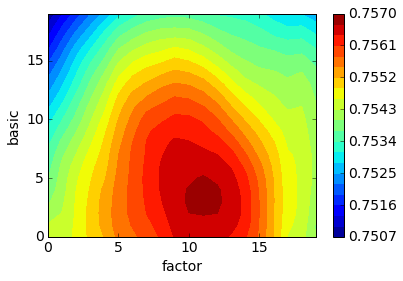

In [22]:
#plt.contourf(np.arange(0, 2, 0.1), cb+np.arange(-2, 2, 0.2), corr, 20)        
plt.contourf(corr[:20, :20], 20)
plt.colorbar()
plt.xlabel('factor')
plt.ylabel('basic')

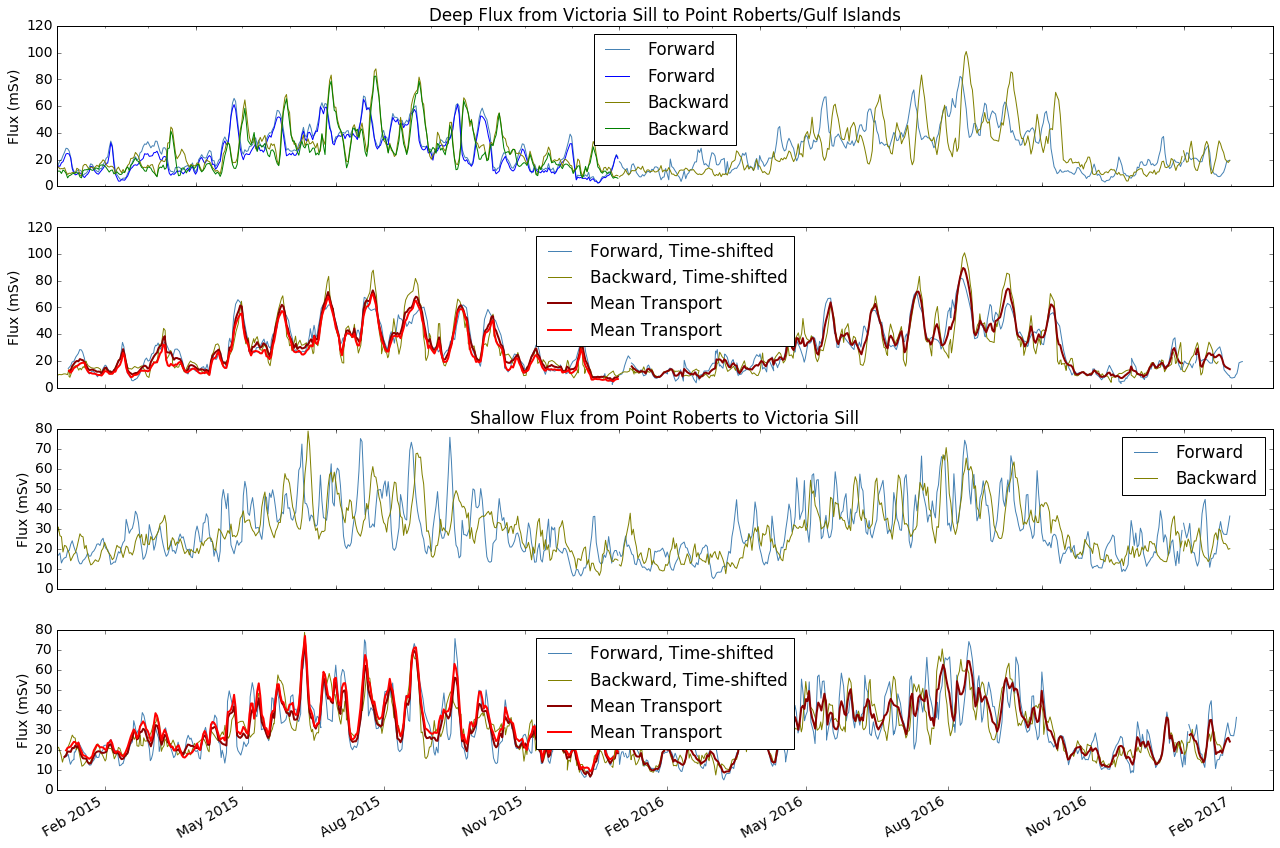

In [25]:
fig, ax = plt.subplots(4, 1, figsize=(18, 12))

ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts/Gulf Islands")
(Vic_to_SoG_2015.transport/1000.).plot(ax=ax[0], label='Forward', color='steelblue')
(Vic_to_SoG_2015_v3.transport/1000.).plot(ax=ax[0], label='Forward', color='blue')
(SoG_from_Vic_2015.transport/1000.).plot(ax=ax[0], label='Backward', color='olive')
(SoG_from_Vic_2015_v3.transport/1000.).plot(ax=ax[0], label='Backward', color='green')
(Vic_to_SoG_2016.transport/1000.).plot(ax=ax[0], label="", color='steelblue')
(SoG_from_Vic_2016.transport/1000.).plot(ax=ax[0], label="", color='olive')
(Vic_to_SoG_2017.transport/1000.).plot(ax=ax[0], label="", color='steelblue')
(SoG_from_Vic_2017.transport/1000.).plot(ax=ax[0], label="", color='olive')

ax[1].plot(Vic_to_SoG_2015.correct_time, Vic_to_SoG_2015.transport/1000., color='steelblue', label='Forward, Time-shifted')
ax[1].plot(SoG_from_Vic_2015.correct_time, SoG_from_Vic_2015.transport/1000., color='olive', label='Backward, Time-shifted')
(deep_flux_2015.transport/1000.).plot(ax=ax[1], color='darkred', linewidth=2, label='Mean Transport')
(deep_flux_2015_v3.transport/1000.).plot(ax=ax[1], color='red', linewidth=2, label='Mean Transport')
ax[1].plot(Vic_to_SoG_2016.correct_time, Vic_to_SoG_2016.transport/1000., color='steelblue', label="")
ax[1].plot(SoG_from_Vic_2016.correct_time, SoG_from_Vic_2016.transport/1000., color='olive', label="")
(deep_flux_2016.transport/1000.).plot(ax=ax[1], color='darkred', linewidth=2, label="")
ax[1].plot(Vic_to_SoG_2017.correct_time, Vic_to_SoG_2017.transport/1000., color='steelblue', label="")
ax[1].plot(SoG_from_Vic_2017.correct_time, SoG_from_Vic_2017.transport/1000., color='olive', label="")
(deep_flux_2017.transport/1000.).plot(ax=ax[1], color='darkred', linewidth=2, label="")

ax[2].set_title("Shallow Flux from Point Roberts to Victoria Sill")
(SoG_to_Vic_2015.transport/1000.).plot(ax=ax[2], label='Forward', color='steelblue')
(Vic_from_SoG_2015.transport/1000.).plot(ax=ax[2], label='Backward', color='olive')
(SoG_to_Vic_2016.transport/1000.).plot(ax=ax[2], label='', color='steelblue')
(Vic_from_SoG_2016.transport/1000.).plot(ax=ax[2], label='', color='olive')
(SoG_to_Vic_2017.transport/1000.).plot(ax=ax[2], label='', color='steelblue')
(Vic_from_SoG_2017.transport/1000.).plot(ax=ax[2], label='', color='olive')

ax[3].plot(SoG_to_Vic_2015.correct_time, SoG_to_Vic_2015.transport/1000., color='steelblue', label='Forward, Time-shifted')
ax[3].plot(Vic_from_SoG_2015.correct_time, Vic_from_SoG_2015.transport/1000., color='olive', label='Backward, Time-shifted')
(shallow_flux_2015.transport/1000.).plot(ax=ax[3], color='darkred', linewidth=2, label='Mean Transport')
(shallow_flux_2015_v3.transport/1000.).plot(ax=ax[3], color='red', linewidth=2, label='Mean Transport')
ax[3].plot(SoG_to_Vic_2016.correct_time, SoG_to_Vic_2016.transport/1000., color='steelblue', label='')
ax[3].plot(Vic_from_SoG_2016.correct_time, Vic_from_SoG_2016.transport/1000., color='olive', label='')
(shallow_flux_2016.transport/1000.).plot(ax=ax[3], color='darkred', linewidth=2, label='')
ax[3].plot(SoG_to_Vic_2017.correct_time, SoG_to_Vic_2017.transport/1000., color='steelblue', label='')
ax[3].plot(Vic_from_SoG_2017.correct_time, Vic_from_SoG_2017.transport/1000., color='olive', label='')
(shallow_flux_2017.transport/1000.).plot(ax=ax[3], color='darkred', linewidth=2, label='')


for axi in ax:
    axi.set_ylabel('Flux (mSv)')
    axi.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 2, 28))
    axi.legend(loc='best')
    
for axi in [ax[0], ax[1], ax[2]]:
    axi.tick_params(
        axis='x', which='both', labelbottom=False)

fig.tight_layout()

## Depths ##

In [41]:
print ('to PR', 0.25*(fullsouth_all_2015.init_depth.mean() + fullsouth_all_2016.init_depth.mean())
       + 0.25*(fullsouth_all_2015.final_depth.mean() + fullsouth_all_2016.final_depth.mean()))
print ('to PR', 0.5*(fullsouth_all_2015.init_depth.mean() + fullsouth_all_2016.init_depth.mean()),
       0.5*(fullsouth_all_2015.final_depth.mean() + fullsouth_all_2016.final_depth.mean()))
print ('to VS', 0.25*(fullnorth_all_2015.init_depth.mean() + fullnorth_all_2016.init_depth.mean())
       + 0.25*(fullnorth_all_2015.final_depth.mean() + fullnorth_all_2016.final_depth.mean()))
print ('to GI', 0.5*(south_gulfislands.final_depth.mean() + south_gulfislands.init_depth.mean()))
print ('at GI', south_gulfislands.final_depth.mean())
print ('to PS/D', 0.5*(south_puget.final_depth.mean() + south_puget.init_depth.mean()))

to PR -72.97870315641413
to PR -62.87296003498079 -83.08444627784746
to VS -28.058060635002715
to GI -51.70378937724074
at GI -40.6183850599234
to PS/D -41.81546851736172


## Calculation of Tides moved to "Calculate Tides" ##
Here just read them

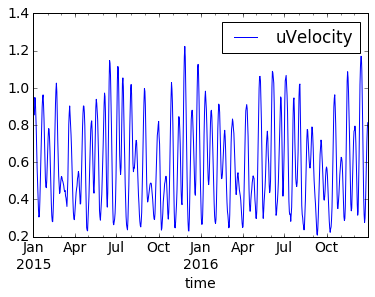

In [268]:
low_pass_tide = pd.read_csv('low_pass_tide.csv', index_col=0)
low_pass_tide.index = pd.to_datetime(low_pass_tide.index, format="%Y-%m-%d")
low_pass_tide.plot()

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


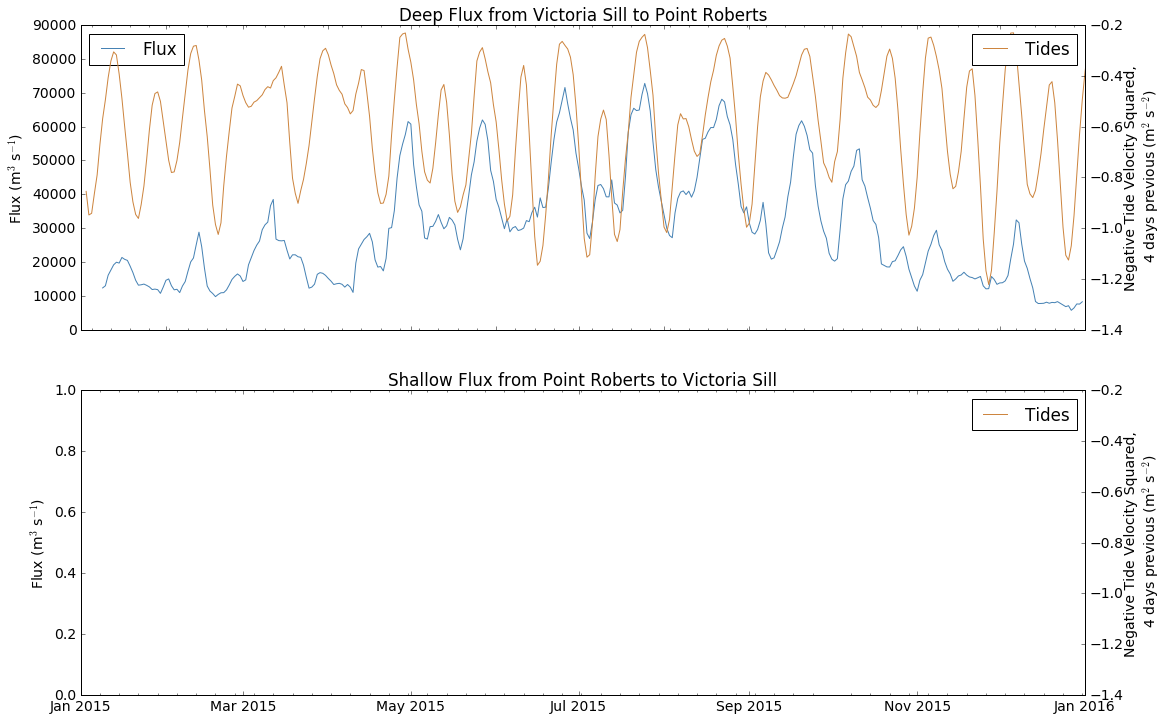

In [367]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
deep_flux_2015.plot(ax=ax[0], y='transport', label="Flux", color='steelblue')
deep_flux_2016.plot(ax=ax[0], y='transport', label="", color='steelblue')
deep_flux_2017.plot(ax=ax[0], y='transport', label="", color='steelblue')
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    (-low_pass_tide.shift(0)).plot(ax=ax2, y='uVelocity', color = 'peru', label='Tides')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2016, 1, 1))
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('Negative Tide Velocity Squared,\n 4 days previous (m$^2$ s$^{-2}$)')

## Summer Deep Water Variability ##

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 190, 300
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

## Spring Deep Water Variability ##

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 100, 190
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

## Winter Deep Water Variability : note change in lag

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -5
ii, jj = 0-lag, 100
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

# Impact of Density Difference #

In [364]:
sigma = pd.read_csv('sigma_2015.csv', index_col=0)
m2015 = sigma.south - sigma.north
m2015.index = pd.to_datetime(m2015.index, format="%Y-%m-%d")

In [374]:
sigma = pd.read_csv('sigma_2016.csv', index_col=0)
m2016 = sigma.south - sigma.north
m2016.index = pd.to_datetime(m2016.index, format="%Y-%m-%d")

In [381]:
sigma = pd.read_csv('sigma_2017.csv', index_col=0)
m2017 = sigma.south - sigma.north
m2017.index = pd.to_datetime(m2017.index, format="%Y-%m-%d")

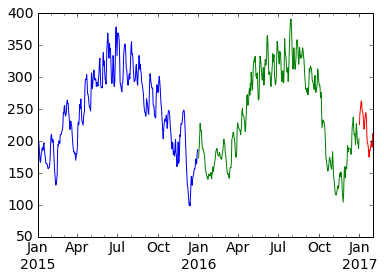

In [375]:
m2015.plot()
m2016.plot()
m2017.plot();

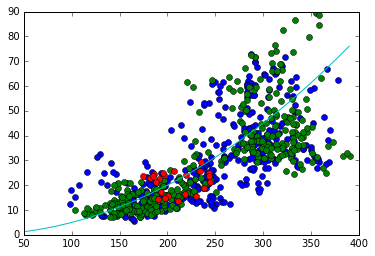

In [406]:
fig, ax = plt.subplots(1, 1)
ax.plot(m2015[:], deep_flux_2015.transport[:]/1000., 'o')
ax.plot(m2016[:], deep_flux_2016.transport[:]/1000., 'o')
ax.plot(m2017[:], deep_flux_2017.transport[:]/1000., 'o')
ax.plot(np.arange(50, 400, 10), np.arange(50, 400, 10)**2/2000.)

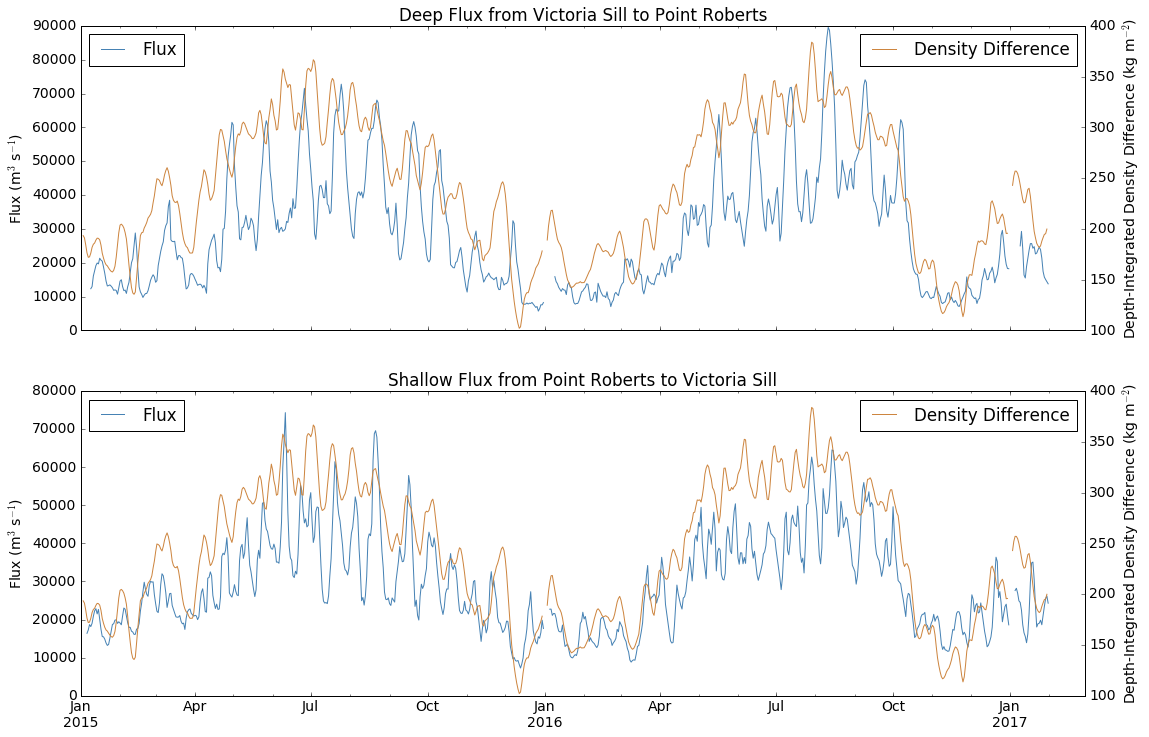

In [376]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))

ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
deep_flux_2015.plot(ax=ax[0], y='transport', label="Flux", color='steelblue')
deep_flux_2016.plot(ax=ax[0], y='transport', label="", color='steelblue')
deep_flux_2017.plot(ax=ax[0], y='transport', label="", color='steelblue')

ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
shallow_flux_2015.plot(ax=ax[1], y='transport', label="Flux", color='steelblue')
shallow_flux_2016.plot(ax=ax[1], y='transport', label="", color='steelblue')
shallow_flux_2017.plot(ax=ax[1], y='transport', label="", color='steelblue')
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    density_line = m2015.rolling(window=4, center=True).mean().plot(
        ax=ax2, label='Density Difference',  color = 'peru')
    density_line = m2016.rolling(window=4, center=True).mean().plot(
        ax=ax2, label='',  color = 'peru')
    density_line = m2017.rolling(window=4, center=True).mean().plot(
        ax=ax2, label='',  color = 'peru')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 3, 1))
    ax2.set_ylabel('Depth-Integrated Density Difference (kg m$^{-2}$)')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

,sigmaD,transport
sigmaD,1.000000,0.723902
transport,0.723902,1.000000


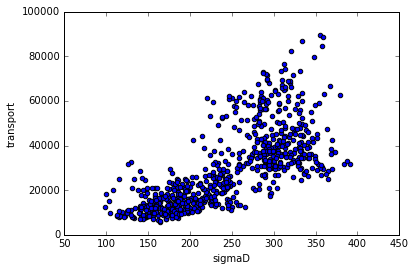

In [445]:
newsa = m2015.append([m2016, m2017])
newsb = deep_flux_2015.transport.append([deep_flux_2016.transport, deep_flux_2017.transport])
newds = pd.DataFrame({'sigmaD': newsa, 'transport': newsb})
newds.plot('sigmaD', 'transport', 'scatter')
newds.corr()

# Wind #

In [368]:
wind = pd.read_csv('day_avg_wind.csv', index_col=0)
wind.index = pd.to_datetime(wind.index, format="%Y-%m-%d")
#low_pass_wind = pd.rolling_mean(day_avg_wind_pd, 4, center=True)

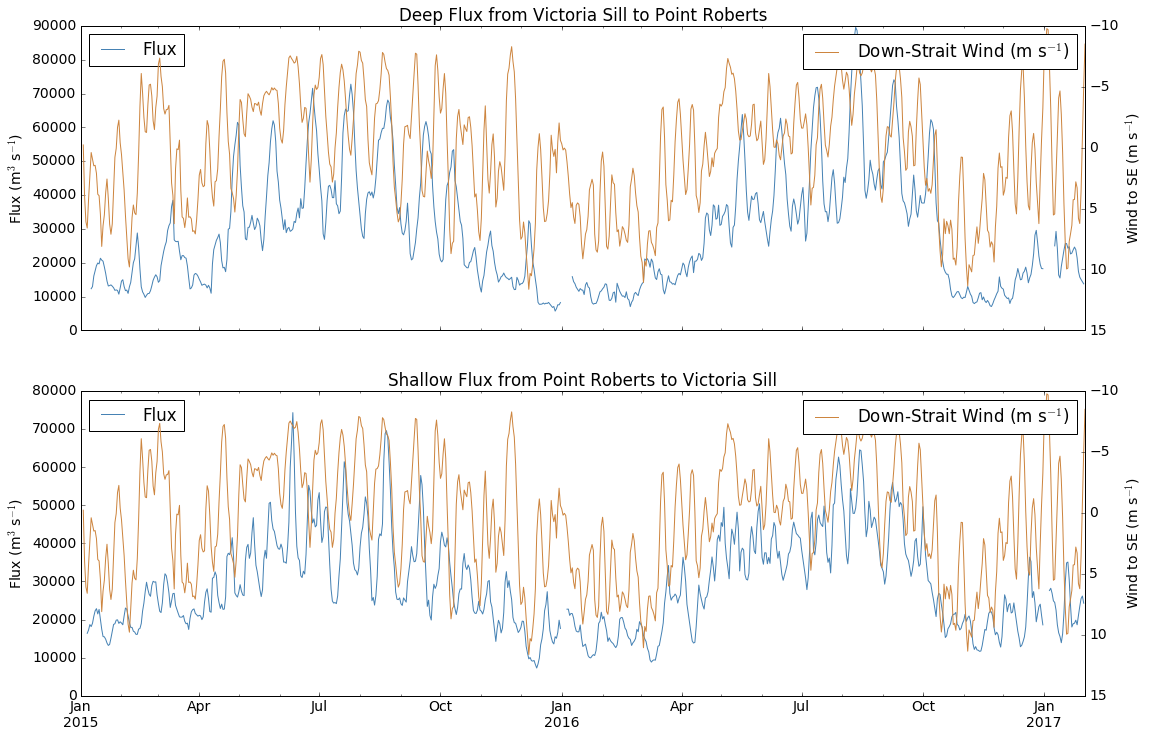

In [373]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
deep_flux_2015.plot(ax=ax[0], y='transport', label="Flux", color='steelblue')
deep_flux_2016.plot(ax=ax[0], y='transport', label="", color='steelblue')
deep_flux_2017.plot(ax=ax[0], y='transport', label="", color='steelblue')
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
shallow_flux_2015.plot(ax=ax[1], y='transport', label="Flux", color='steelblue')
shallow_flux_2016.plot(ax=ax[1], y='transport', label="", color='steelblue')
shallow_flux_2017.plot(ax=ax[1], y='transport', label="", color='steelblue')
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    wind.rolling(window=4, center=True).mean().plot(ax=ax2, y='wind', legend=False, label='Down-Strait Wind (m s$^{-1}$)',  color = 'peru')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 2, 1))
    ax2.set_ylabel('Wind to SE (m s$^{-1}$)')
    ax2.invert_yaxis()
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

,sigmaD,transport,wind
sigmaD,1.000000,0.723902,-0.579269
transport,0.723902,1.000000,-0.349371
wind,-0.579269,-0.349371,1.000000


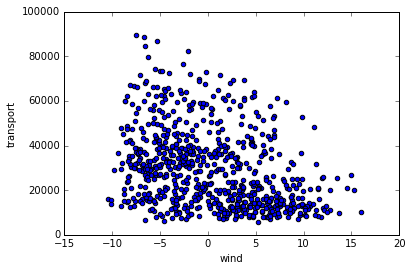

In [453]:
newds2 = pd.DataFrame({'sigmaD': newsa[:762], 'wind': wind.wind[:762], 'transport': newsb[:762]})
newds2.plot('wind', 'transport', 'scatter')
newds2.corr()

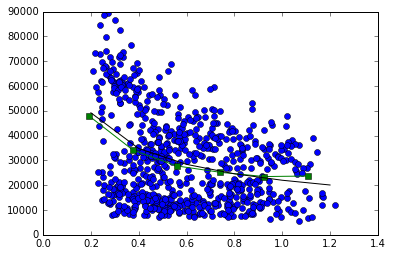

In [516]:
length = 731
newds3 = pd.DataFrame({'sigmaD': newsa[:length], 
                       'wind': wind.wind[:length], 
                       'tides': low_pass_tide.uVelocity[:length], 
                       'ratio' : newsa[:length]/low_pass_tide.uVelocity[:length],
                       'transport': newsb[:length]})
plt.plot(newds3.set_index('tides').transport, 'o')
bins = np.linspace(0.1, 1.2, 7)
plot_centers = (bins [:-1] + bins[1:])/2
group = newds3.groupby(pd.cut(newds3.tides, bins))
plot_values = group.transport.mean()
plt.plot(plot_centers, plot_values, 's-')
#newds3.plot.hexbin('tides', 'transport', gridsize=10)
plt.plot(np.arange(0.2, 1.4, 0.2), 22000./np.sqrt(np.arange(0.2, 1.4, 0.2)), 'k')

In [461]:
newds3.transport[365:370]

time
2016-01-01   NaN
2016-01-02   NaN
2016-01-03   NaN
2016-01-04   NaN
2016-01-05   NaN
Freq: D, Name: transport, dtype: float64

In [473]:
import statsmodels.api as sm
y = newds3.transport[8:365]
x = newds3[['ratio', 'wind']][8:365]
x = sm.add_constant(x)
model11 = sm.OLS(y, x).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              transport   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     225.3
Date:                Wed, 05 Sep 2018   Prob (F-statistic):           7.65e-64
Time:                        17:47:18   Log-Likelihood:                -3824.3
No. Observations:                 357   AIC:                             7655.
Df Residuals:                     354   BIC:                             7666.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       5175.0744   1324.126      3.908      0.000      2570.933  7779.216
ratio         50.5209      2.465     20.494      0.000        45.673    55.369
wind        -277.3991    105.241     -2.636      0.009      -484.375   -70.423
==============================================================================
Omnibus:                       16.843   Durbin-Watson:                   0.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.333
Skew:                           0.026   Prob(JB):                       0.0256
Kurtosis:                       2.300   Cond. No.                     1.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [476]:
y = newds3.transport[8:365]
x = newds3[['ratio']][8:365]
x = sm.add_constant(x)
model11 = sm.OLS(y, x).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              transport   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     436.4
Date:                Wed, 05 Sep 2018   Prob (F-statistic):           9.09e-64
Time:                        17:51:47   Log-Likelihood:                -3827.8
No. Observations:                 357   AIC:                             7660.
Df Residuals:                     355   BIC:                             7667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       4844.2635   1329.161      3.645      0.000      2230.244  7458.283
ratio         51.4230      2.462     20.889      0.000        46.582    56.264
==============================================================================
Omnibus:                       16.673   Durbin-Watson:                   0.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.359
Skew:                           0.048   Prob(JB):                       0.0252
Kurtosis:                       2.303   Cond. No.                     1.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [475]:
y = newds3.transport[8:365]
x = newds3[['sigmaD', 'tides', 'wind']][8:365]
x = sm.add_constant(x)
model11 = sm.OLS(y, x).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              transport   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     190.2
Date:                Wed, 05 Sep 2018   Prob (F-statistic):           2.19e-73
Time:                        17:49:50   Log-Likelihood:                -3799.2
No. Observations:                 357   AIC:                             7606.
Df Residuals:                     353   BIC:                             7622.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -3042.1559   2892.291     -1.052      0.294     -8730.445  2646.133
sigmaD       202.1803     10.244     19.737      0.000       182.034   222.327
tides      -2.835e+04   2296.257    -12.344      0.000     -3.29e+04 -2.38e+04
wind         490.2362    115.314      4.251      0.000       263.446   717.026
==============================================================================
Omnibus:                        5.936   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.238
Skew:                           0.226   Prob(JB):                       0.0729
Kurtosis:                       2.615   Cond. No.                     1.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

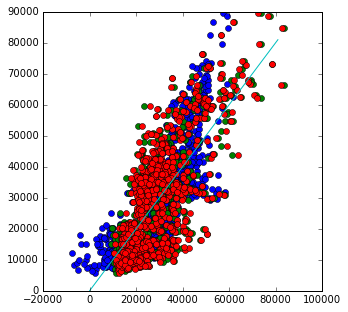

In [477]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(-3042.16+ 202.18*newds3.sigmaD 
         - 2.835e4*newds3.tides 
         + 490.24*newds3.wind, newds3.transport, 'o')
ax.plot(5175.1 + 50.52*newds3.ratio -277.4*newds3.wind, newds3.transport, 'o')
ax.plot(4844.3 + 51.42*newds3.ratio, newds3.transport, 'o')
ax.plot(range(0,90000, 9000), range(0, 90000,9000))